In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import random

In [2]:
# load dataset
dataset = h5py.File('data/3dshapes.h5', 'r')
print(dataset.keys())
images = dataset['images']  # array shape [480000,64,64,3], uint8 in range(256)
labels = dataset['labels']  # array shape [480000,6], float64
image_shape = images.shape[1:]  # [64,64,3]
label_shape = labels.shape[1:]  # [6]
n_samples = labels.shape[0]  # 10*10*10*8*4*15=480000
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape',
                     'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

<KeysViewHDF5 ['images', 'labels']>


In [3]:
# Number of samples to select
n_samples_to_select = 50000

# Randomly sample indices from the total number of samples
random_indices = np.random.choice(n_samples, n_samples_to_select, replace=False)
random_indices.sort()
# Select the sampled images and labels
sampled_images = images[random_indices]
sampled_labels = labels[random_indices]

In [4]:
normalized_images = sampled_images / 255.0
normalized_images = normalized_images.transpose(0, 3, 1, 2)
print(normalized_images.shape)

(50000, 3, 64, 64)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=6): # latent dim is 6 because we have 6 ground truth factors in the dataset
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=4, stride=1, padding=0),  # 4x4 -> 1x1
            nn.ReLU(),
            nn.Conv2d(256, latent_dim, kernel_size=1, stride=1, padding=0),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 256, 1), 
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=1, padding=0), # 1x1 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Ensures output is within [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
import torch.nn.functional as F

def ae_loss(recon, x):
    # we use sigmoid so we use binary cross entropy rather than MSE to provide a better gradient

    # reduction='mean' will average across batch, channels, height, and width.
    recon_loss = F.binary_cross_entropy(recon, x, reduction='mean')
    return recon_loss


In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Prepare dataset and dataloader
batch_size = 64
tensor_images = torch.tensor(normalized_images, dtype=torch.float32)
dataset = TensorDataset(tensor_images)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Add learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

previous_lr = scheduler.get_last_lr()

In [8]:
# Training loop
n_epochs = 15
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        images = batch[0].to(device)
        optimizer.zero_grad()
        reconstructed = model(images)
        loss = ae_loss(reconstructed, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    
    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].to(device)
            reconstructed = model(images)
            loss = ae_loss(reconstructed, images)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Check if the learning rate has changed
    current_lr = scheduler.get_last_lr()
    if current_lr != previous_lr:
        print(f"Learning rate changed: {previous_lr} -> {current_lr}")
        previous_lr = current_lr
    
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/15, Train Loss: 0.4540, Val Loss: 0.3394
Epoch 2/15, Train Loss: 0.3318, Val Loss: 0.3273
Epoch 3/15, Train Loss: 0.3223, Val Loss: 0.3177
Epoch 4/15, Train Loss: 0.3161, Val Loss: 0.3151
Epoch 5/15, Train Loss: 0.3129, Val Loss: 0.3118
Epoch 6/15, Train Loss: 0.3108, Val Loss: 0.3152
Epoch 7/15, Train Loss: 0.3092, Val Loss: 0.3071
Epoch 8/15, Train Loss: 0.3061, Val Loss: 0.3054
Epoch 9/15, Train Loss: 0.3046, Val Loss: 0.3033
Epoch 10/15, Train Loss: 0.3032, Val Loss: 0.3024
Epoch 11/15, Train Loss: 0.3020, Val Loss: 0.3009
Epoch 12/15, Train Loss: 0.3008, Val Loss: 0.3000
Epoch 13/15, Train Loss: 0.3017, Val Loss: 0.2988
Epoch 14/15, Train Loss: 0.2987, Val Loss: 0.2981
Epoch 15/15, Train Loss: 0.2982, Val Loss: 0.2976


In [ ]:
# save the trained model

torch.save({
    'AE_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
}, "AE_checkpoint.pth")

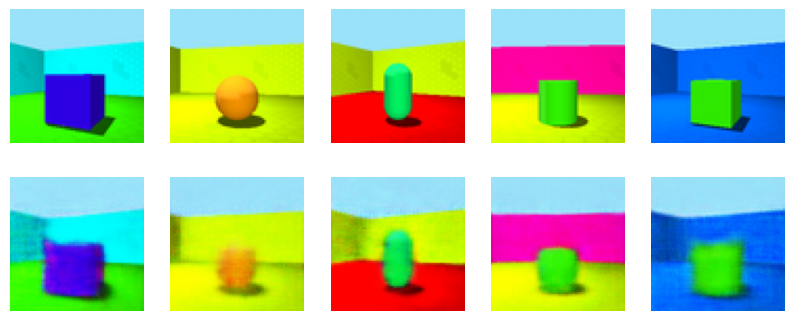

In [ ]:
def visualize_reconstruction(model, dataset, n_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), n_images)
    images = torch.stack([dataset[i][0] for i in indices]).to(device)
    with torch.no_grad():
        reconstructed = model(images)
    
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to HWC for visualization
    reconstructed = reconstructed.cpu().numpy().transpose(0, 2, 3, 1)
    
    plt.figure(figsize=(10, 4))
    for i in range(n_images):
        # Original image
        plt.subplot(2, n_images, i+1)
        plt.imshow(images[i])
        plt.axis('off')
        # Reconstructed image
        plt.subplot(2, n_images, i+n_images+1)
        plt.imshow(np.clip(reconstructed[i], 0, 1))  # Ensure valid range
        plt.axis('off')
    plt.show()

visualize_reconstruction(model, val_dataset)


In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(feature=64).to(device)

# Compute FID after training:
model.eval()
real_images_list = []
fake_images_list = []

# Gather a subset of real images from the dataset
subset_indices = np.random.choice(len(val_dataset), 1000, replace=False)
real_images_subset = torch.stack([val_dataset[i][0] for i in subset_indices]).to(device)

with torch.no_grad():
    # Get reconstructed images
    reconstructed_images = []
    for i in range(0, len(real_images_subset), batch_size):
        batch = real_images_subset[i:i+batch_size]
        rec = model(batch)
        reconstructed_images.append(rec.cpu())
    reconstructed_images = torch.cat(reconstructed_images, dim=0)

# Ensure real images are scaled to [0, 255] and converted to uint8
real_images_subset = (real_images_subset * 255).clamp(0, 255).byte()

# Ensure reconstructed images are scaled to [0, 255] and converted to uint8
reconstructed_images = (reconstructed_images * 255).clamp(0, 255).byte()

# Add real and reconstructed images to FID:
fid.update(real_images_subset.cpu(), real=True)
fid.update(reconstructed_images, real=False)
fid_score = fid.compute().item()
print(f"FID Score: {fid_score:.4f}")


FID Score: 0.0641


In [ ]:
# Compute latent stats

val_images = torch.stack([val_dataset[i][0] for i in range(len(val_dataset))])  # Convert dataset to tensor
val_images = val_images.to(device)

batch = val_images[:1000]  # sample first 1000

model.eval()
with torch.no_grad():
    # Take a subset from val_dataset as before
    val_images = torch.stack([val_dataset[i][0] for i in range(len(val_dataset))])
    val_images = val_images.to(device)
    batch = val_images[:1000]

    encoded = model.encoder(batch)  # shape [1000, latent_dim, 1, 1]
    encoded = encoded.squeeze(-1).squeeze(-1)  # shape [1000, latent_dim]

    mean_z = encoded.mean(dim=0)
    std_z = encoded.std(dim=0)

# take variation range within mean +/- 1 std
variation_ranges = [(mean_z[i].item() - std_z[i].item(), mean_z[i].item() + std_z[i].item()) 
                    for i in range(model.latent_dim)]

print("Latent dimension variation ranges:")
for i, (low, high) in enumerate(variation_ranges):
    print(f"Dimension {i + 1}: [{low:.4f}, {high:.4f}]")



Latent dimension variation ranges:
Dimension 1: [-1.0749, 82.6685]
Dimension 2: [-55.0960, 31.6253]
Dimension 3: [-55.7266, 27.7180]
Dimension 4: [-4.5976, 72.4678]
Dimension 5: [-73.0925, 34.2032]
Dimension 6: [-35.9544, 77.0667]


### Autoencoder does not enforce a unit Gaussian posterior, so the range of dimension values are large (not about +- 1)

In [22]:
def latent_space_traversal(model, n_samples=5, dim_to_vary=0, variation_range=(-3, 3), steps=10):
    model.eval()
    variation_values = torch.linspace(variation_range[0], variation_range[1], steps)
    random_indices = np.random.choice(len(val_dataset), n_samples, replace=False)
    images = torch.stack([val_dataset[i][0] for i in random_indices]).to(device)

    with torch.no_grad():
        encoded = model.encoder(images)  # [n_samples, latent_dim, 1, 1]
        encoded_flat = encoded.squeeze(-1).squeeze(-1)  # [n_samples, latent_dim]
        
        plt.figure(figsize=(steps * 2, n_samples * 2))
        
        for i in range(n_samples):
            base_latent = encoded_flat[i].clone()
            
            for j, value in enumerate(variation_values):
                varied_latent = base_latent.clone()
                varied_latent[dim_to_vary] = value
                
                # Reshape and decode
                varied_latent_reshaped = varied_latent.view(1, model.latent_dim, 1, 1)
                decoded = model.decoder(varied_latent_reshaped)
                decoded_img = decoded.cpu().squeeze(0).permute(1, 2, 0).numpy()

                plt.subplot(n_samples, steps, i * steps + j + 1)
                plt.imshow(np.clip(decoded_img, 0, 1))
                plt.axis("off")
    
    plt.tight_layout()
    plt.show()


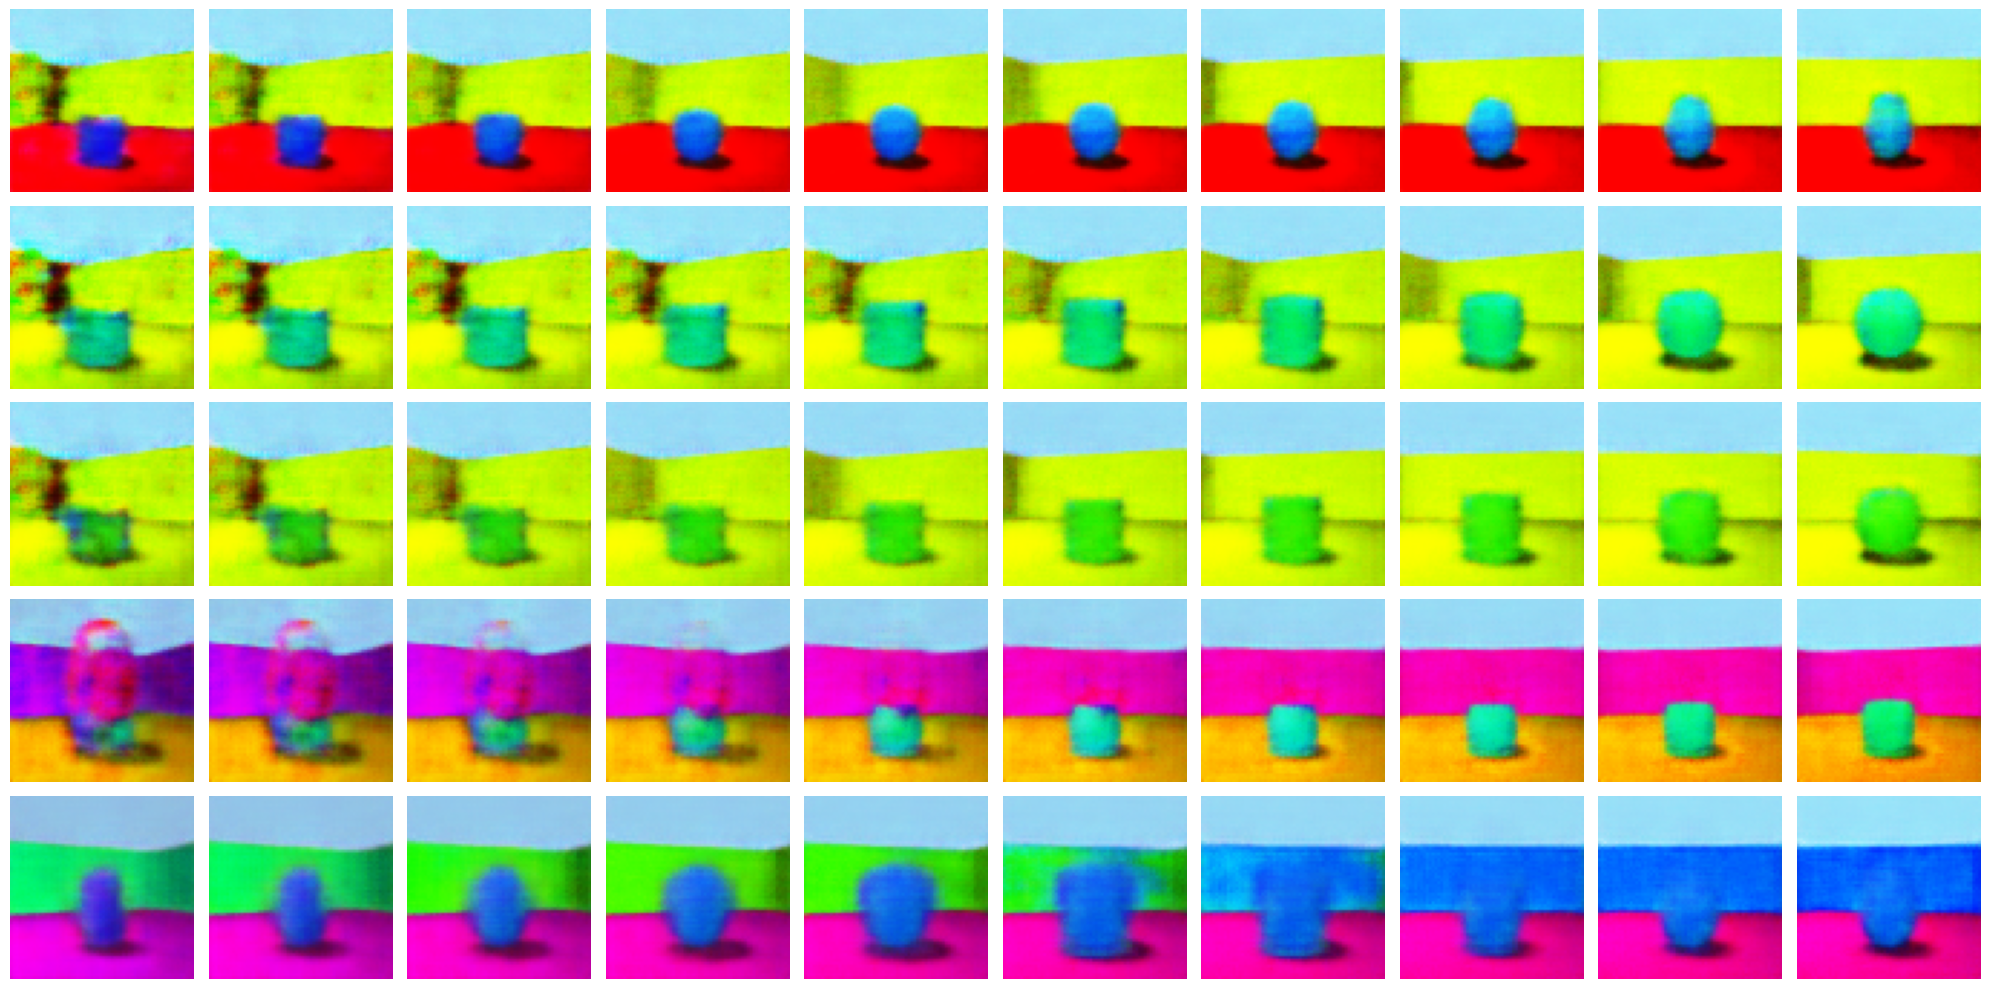

In [23]:
# Perform latent space traversal
latent_space_traversal(model, n_samples=5, dim_to_vary=0, variation_range=variation_ranges[0], steps=10)

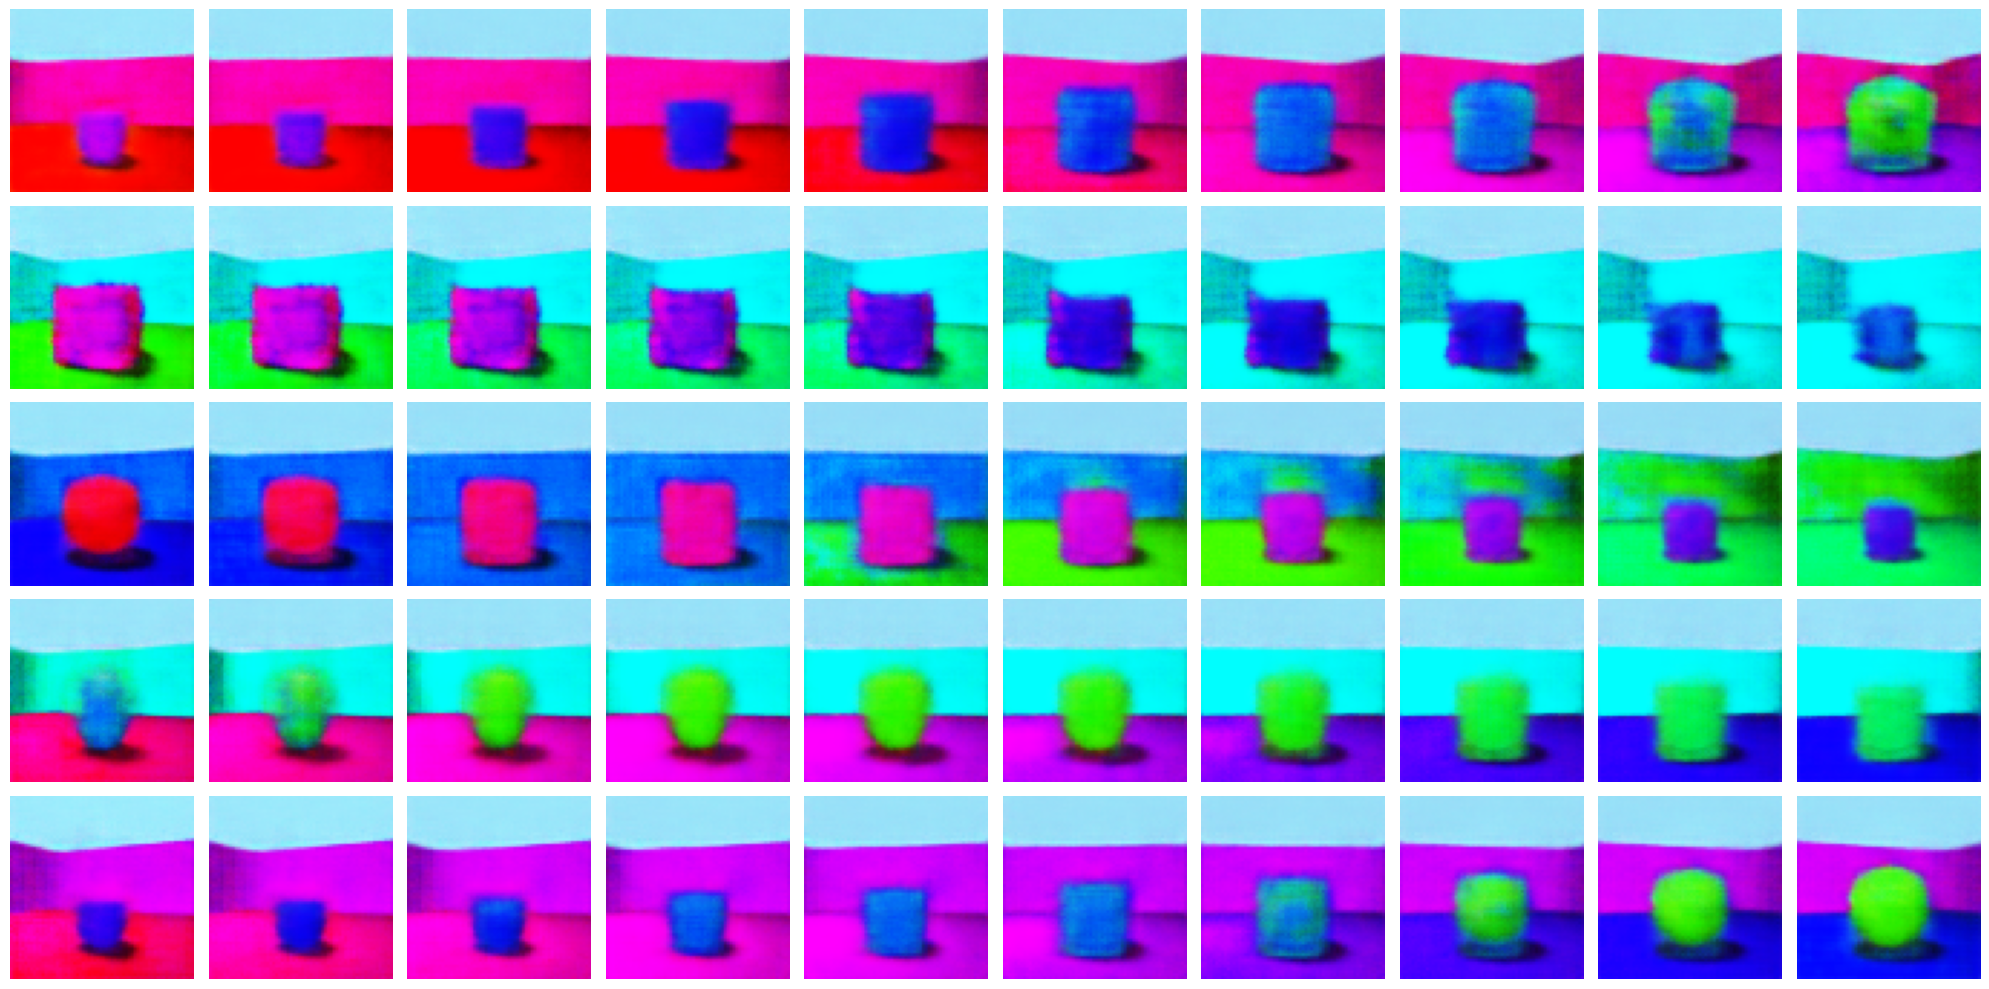

In [24]:
# Perform latent space traversal
latent_space_traversal(model, n_samples=5, dim_to_vary=1, variation_range=variation_ranges[1], steps=10)

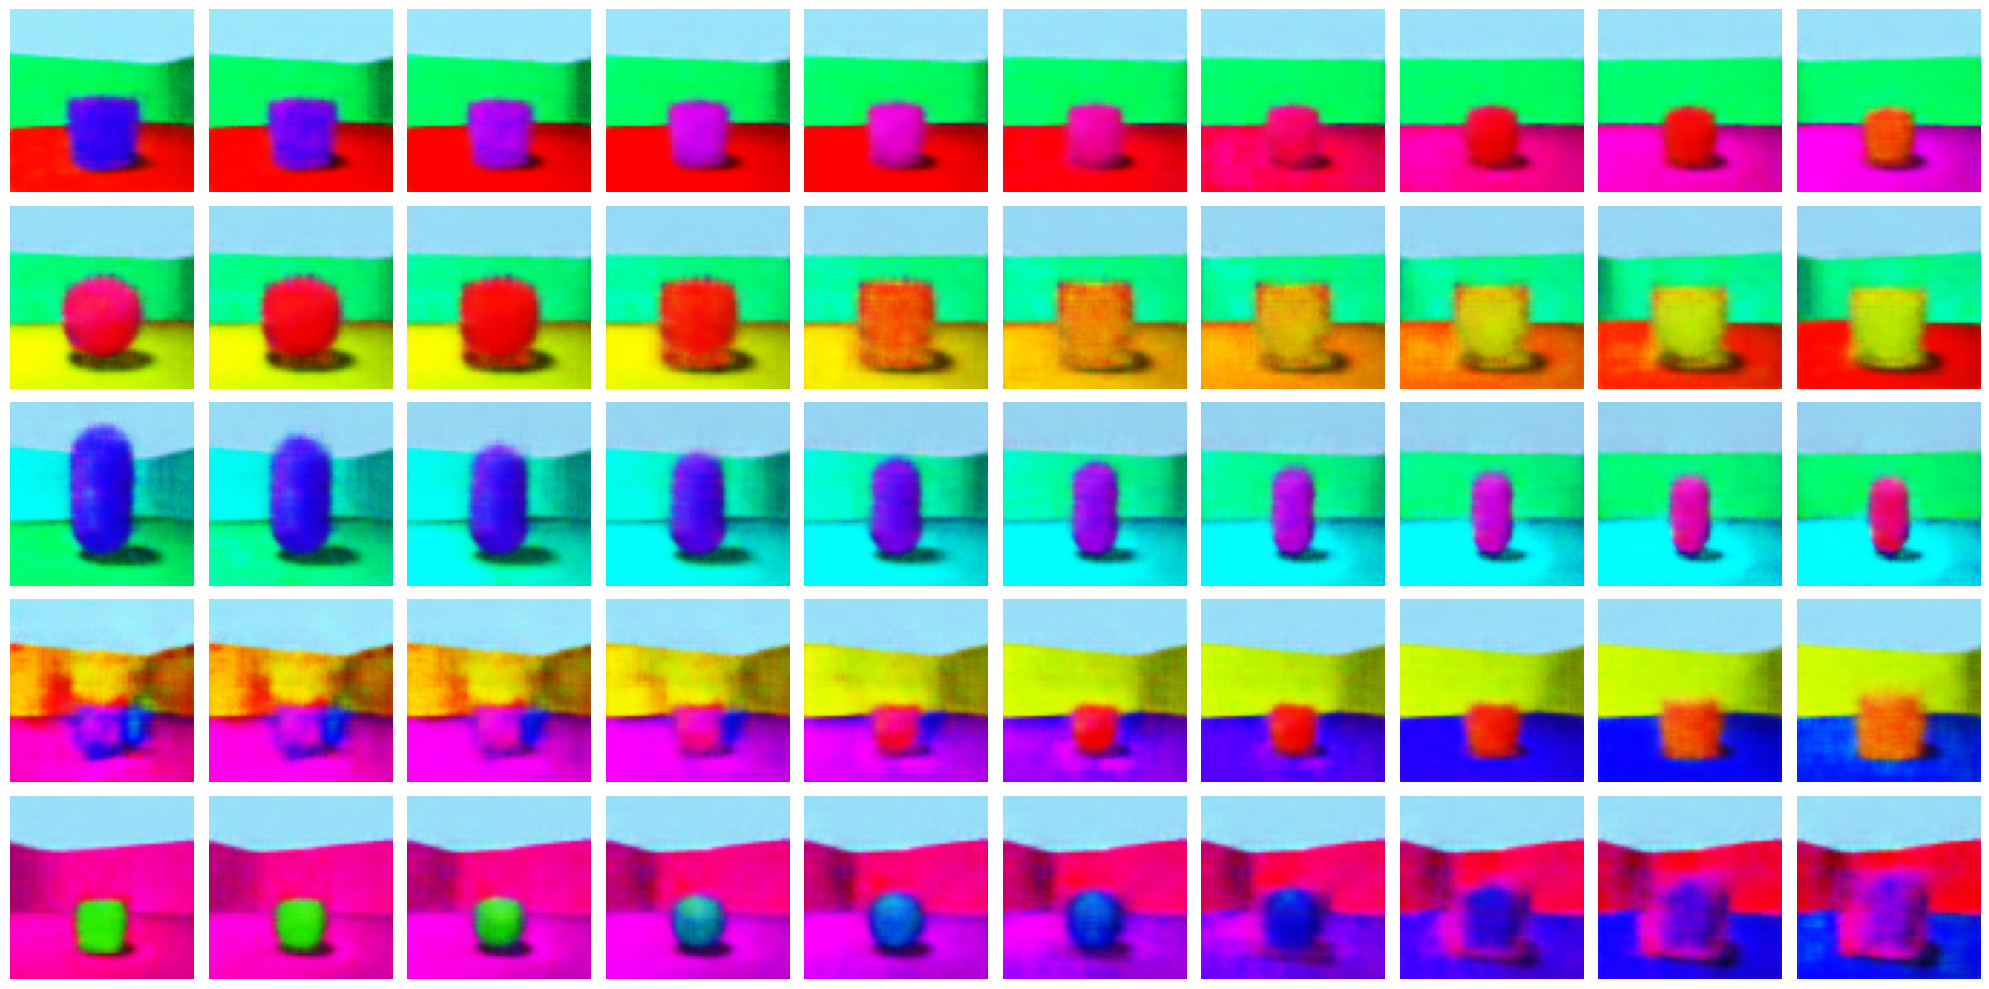

In [25]:
# Perform latent space traversal
latent_space_traversal(model, n_samples=5, dim_to_vary=2, variation_range=variation_ranges[2], steps=10)

In [ ]:
import torch
import numpy as np
import math
import matplotlib.pyplot as plt

model.eval()

# Use a subset of the sampled_images for MIG calculation
n_eval_samples = 10000
if n_eval_samples > sampled_images.shape[0]:
    n_eval_samples = sampled_images.shape[0]
eval_indices = np.random.choice(sampled_images.shape[0], n_eval_samples, replace=False)

eval_images = sampled_images[eval_indices]  # shape: [n_eval_samples, 64, 64, 3] originally
eval_labels = sampled_labels[eval_indices]   # shape: [n_eval_samples, 6]

# Normalize and prepare Torch tensor
eval_images_normalized = eval_images / 255.0
eval_images_normalized = eval_images_normalized.transpose(0, 3, 1, 2)
eval_tensor = torch.tensor(eval_images_normalized, dtype=torch.float32, device=device)

batch_size_eval = 64
eval_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(eval_tensor), 
                                          batch_size=batch_size_eval, shuffle=False)

all_latents = []
with torch.no_grad():
    for batch in eval_loader:
        imgs = batch[0].to(device)
        encoded = model.encoder(imgs)
        z = encoded.squeeze(-1).squeeze(-1)  # [B, latent_dim]
        all_latents.append(z.cpu().numpy())


all_latents = np.concatenate(all_latents, axis=0)  # [n_eval_samples, 6]
all_factors = eval_labels  # [n_eval_samples, 6]

print("Latents shape:", all_latents.shape)
print("Factors shape:", all_factors.shape)

# MIG calculation
_FACTORS_IN_ORDER = ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']
_NUM_VALUES_PER_FACTOR = {'floor_hue': 10, 'wall_hue': 10, 'object_hue': 10, 
                          'scale': 8, 'shape': 4, 'orientation': 15}

def discrete_mutual_info(z_discrete, factors):
    # Compute discrete mutual info between each latent dim and each factor
    N, L = z_discrete.shape
    F_ = factors.shape[1]
    MI = np.zeros((L, F_))
    for i in range(L):
        z_vals = z_discrete[:, i]
        for j in range(F_):
            f_vals = factors[:, j]
            # Build joint histogram
            z_unique = np.unique(z_vals)
            f_unique = np.unique(f_vals)
            joint, _, _ = np.histogram2d(z_vals, f_vals, 
                                         bins=(len(z_unique), len(f_unique)))
            joint = joint / joint.sum()
            z_marginal = joint.sum(axis=1, keepdims=True)
            f_marginal = joint.sum(axis=0, keepdims=True)
            epsilon = 1e-12
            numerator = joint + epsilon
            denominator = z_marginal.dot(f_marginal) + epsilon
            MI_ij = (joint * np.log(numerator / denominator)).sum()
            MI[i, j] = MI_ij
    return MI

def compute_mig(latents, factors, num_bins=20):
    # Discretize factors
    disc_factors = []
    factor_cardinalities = []
    for i, factor_name in enumerate(_FACTORS_IN_ORDER):
        unique_vals = np.unique(factors[:, i])
        # Map factor values to integers
        val_to_int = {v: idx for idx, v in enumerate(unique_vals)}
        disc_factors.append(np.array([val_to_int[v] for v in factors[:, i]]))
        factor_cardinalities.append(len(unique_vals))
    disc_factors = np.stack(disc_factors, axis=1)

    # Discretize latents into bins
    z_min = latents.min(axis=0)
    z_max = latents.max(axis=0)
    z_discrete = np.zeros_like(latents, dtype=int)
    for d in range(latents.shape[1]):
        bins = np.linspace(z_min[d], z_max[d], num_bins + 1)
        z_discrete[:, d] = np.digitize(latents[:, d], bins) - 1
    
    MI = discrete_mutual_info(z_discrete, disc_factors)

    # MIG: difference between top two MI scores for each latent / log of factor cardinality
    MIG_list = []
    for l in range(MI.shape[0]):
        sorted_mi = np.sort(MI[l, :])[::-1]
        if len(sorted_mi) < 2:
            continue
        top_factor_index = np.argmax(MI[l, :])
        top_factor_cardinality = factor_cardinalities[top_factor_index]
        mig_l = (sorted_mi[0] - sorted_mi[1]) / math.log(top_factor_cardinality + 1e-12)
        MIG_list.append(mig_l)
    mig_score = np.mean(MIG_list)
    return mig_score

mig_score = compute_mig(all_latents, all_factors, num_bins=20)
print("MIG score:", mig_score)

Latents shape: (10000, 6)
Factors shape: (10000, 6)
MIG score: 0.15159992498641395


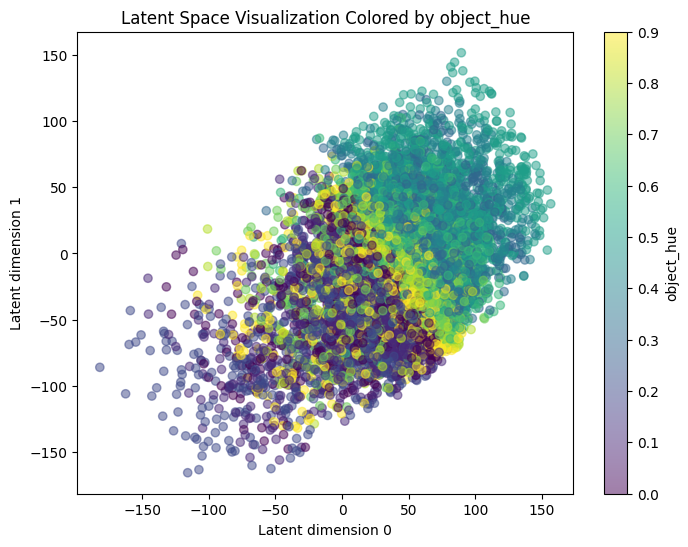

In [32]:
# Visualization Example:
# Let's visualize how "object_hue" is reflected in two latent dimensions.
factor_index = 2  # 'object_hue'
factor_values = all_factors[:, factor_index]

dim_x = 0  # e.g., choose dimension 0
dim_y = 1  # e.g., choose dimension 1
latent_x = all_latents[:, dim_x]
latent_y = all_latents[:, dim_y]

plt.figure(figsize=(8,6))
scatter = plt.scatter(latent_x, latent_y, c=factor_values, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label=_FACTORS_IN_ORDER[factor_index])
plt.xlabel(f"Latent dimension {dim_x}")
plt.ylabel(f"Latent dimension {dim_y}")
plt.title(f"Latent Space Visualization Colored by {_FACTORS_IN_ORDER[factor_index]}")
plt.show()

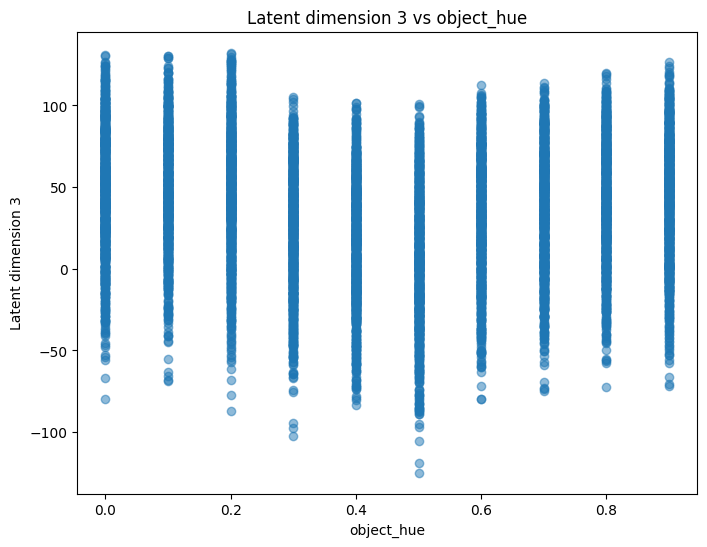

In [33]:
# Visualization Example (one latent dimension vs one factor)
factor_index = 2  # 'object_hue' as an example
factor_values = all_factors[:, factor_index]

dim_x = 3  # Choose a single latent dimension to visualize
latent_x = all_latents[:, dim_x]

plt.figure(figsize=(8,6))
plt.scatter(factor_values, latent_x, alpha=0.5)
plt.xlabel(_FACTORS_IN_ORDER[factor_index])
plt.ylabel(f"Latent dimension {dim_x}")
plt.title(f"Latent dimension {dim_x} vs {_FACTORS_IN_ORDER[factor_index]}")
plt.show()